In [1]:
import numpy as np
import cv2           
import matplotlib.pyplot as plt
%matplotlib inline
FIGSIZE = (10,8)

# Rapport 11/02 - Algorithme de Calibration 

Voici les deux algorithmes qui ont été développés pour trouver les informations de la grille de micro-lentilles. Ces algos sont similaires et ne se différencient que par la méthode de construction de la grille et l'obtention des informations.

D'abord, les fonction communes seront présentés et après chaque méthode sera mieux détailler dans la section correspondante.

## Fonctions communes

In [16]:
def generate_threshold_img(image, gauss_kernel, block_size, c):
    # Extract the first channel (assuming it's a grayscale image)
    gray = image[:, :, 0]

    # Apply Gaussian blur to reduce noise
    gray = cv2.GaussianBlur(gray, gauss_kernel, 0)
    
    # Apply adaptive thresholding using mean of neighborhood as the threshold value
    # Pixels with values above the threshold become white, and below become black
    thresh = cv2.adaptiveThreshold(gray, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, block_size, c)

    # Return the thresholded image
    return thresh

In [3]:
def intensity_hist(image, axis=0, show_plot=False):
    # Transpose the image if 'axis' is set to 1
    img = image if axis == 0 else image.T
    
    # Calculate the row-wise sum of pixel values, considering 255 as the maximum intensity
    intensity = [row.sum() // 255 for row in img]

    # Return the calculated intensity histogram
    return intensity

In [4]:
def pairwise_distances(values):
    num_points, num_features = values.shape
    distances = np.zeros((num_points, num_points))
    for i in range(num_points):
        for j in range(num_points):
            distances[i, j] = np.sqrt(np.sum((values[i] - values[j]) ** 2))

    return distances

def cluster_values(values, threshold):
    # Convert values to a 2D array
    values = np.array(values).reshape(-1, 1)
    # Use cdist to calculate pairwise distances
    distances = pairwise_distances(values)
    # Create an adjacency matrix based on the threshold
    adjacency_matrix = distances < threshold
    # Initialize clusters
    clusters = []
    # Iterate through each value
    for i in range(len(values)):
        found_cluster = False
        # Check existing clusters
        for cluster in clusters:
            if any(adjacency_matrix[i, c] for c in cluster):
                cluster.append(i)
                found_cluster = True
                break
        # If the value doesn't belong to any existing cluster, create a new cluster
        if not found_cluster:
            clusters.append([i])
    # Convert indices to values
    clustered_values = [[values[i][0] for i in cluster] for cluster in clusters]
    return clustered_values

In [5]:
def get_peaks(intensity_hist, cluster_distance):
    # Compute the first derivative of the intensity histogram
    first_derivative = np.diff(intensity_hist)
    
    # Find the indices where the first derivative changes sign from positive to negative or is zero
    potential_peaks = np.where((first_derivative[:-1] >= 0) & (first_derivative[1:] <= 0))[0] + 1
    
    # Cluster values around potential peaks
    intensity_clust = cluster_values(potential_peaks, cluster_distance)
    
    # Calculate the mean intensity for each cluster
    for i in range(len(intensity_clust)):
        intensity_clust[i] = np.mean(intensity_clust[i])
        
    return intensity_clust

In [6]:
def get_circles(image, cluster_distance=3, show_plot=True):
    # Get peaks along X and Y axes
    intensity_x = intensity_hist(image)
    peaks_x = get_peaks(intensity_x, cluster_distance)
    
    intensity_y = intensity_hist(image.T)
    peaks_y = get_peaks(intensity_y, cluster_distance)
    
    # Generate circles based on peak locations
    circles = [(x, y) for x in peaks_x for y in peaks_y]
    
    if show_plot:
        plt.figure(figsize=(10,6))
        plt.subplot(1,2,1)
        plt.plot(range(len(intensity_x)), intensity_x, color='blue')
        for i, x in enumerate(peaks_x):
            plt.scatter(peaks_x, [512 for _ in range(len(peaks_x))], color='blue')
        plt.title("X Intensity histogram")

        plt.subplot(1,2,2)
        plt.plot(range(len(intensity_y)), intensity_y, color='green')
        for j, y in enumerate(peaks_y):
            plt.scatter(peaks_y, [512 for _ in range(len(peaks_y))], color='green')
        plt.title("Y Intensity histogram")
        plt.show()
    return np.array(circles), len(peaks_x), len(peaks_y)

## Non-Regular Grid

In [7]:
def compute_mean_diameter(circles):
    if len(circles) < 2:
        raise ValueError("At least two circles are required to compute mean diameter.")

    # Extract x, y coordinates of circle centers
    centers = np.array(circles)

    # Compute the differences along the X-axis
    axis_distances = np.diff(centers[:, 0])
    
    # Compute the mean diameter
    mean_diameter = np.mean(axis_distances[axis_distances != 0])
    return mean_diameter

def fit_grid(image, cluster_distance, plot_hist=False):
    # Get peaks along X and Y axes
    intensity_x = intensity_hist(image)
    peaks_x = get_peaks(intensity_x, cluster_distance)
    
    intensity_y = intensity_hist(image.T)
    peaks_y = get_peaks(intensity_y, cluster_distance)
    
    # Calculate half of the differences between peaks
    x_diff = np.diff(peaks_x)/2
    y_diff = np.diff(peaks_y)/2

    # Construct grid along X-axis
    grid_x = np.concatenate(([peaks_x[0] - x_diff[0]], peaks_x[:-1] + x_diff, [peaks_x[-1] + x_diff[-1]]))
    
    # Construct grid along Y-axis
    grid_y = np.concatenate(([peaks_y[0] - y_diff[0]], peaks_y[:-1] + y_diff, [peaks_y[-1] + y_diff[-1]]))
    
    if plot_hist:
        plt.figure(figsize=(10,6))
        plt.subplot(1,2,1)
        plt.plot(range(len(intensity_x)), intensity_x, color='blue')
        for i, x in enumerate(peaks_x):
            plt.scatter(peaks_x, [512 for _ in range(len(peaks_x))], color='blue')
        plt.title("X Intensity Histogram")

        plt.subplot(1,2,2)
        plt.plot(range(len(intensity_y)), intensity_y, color='green')
        for j, y in enumerate(peaks_y):
            plt.scatter(peaks_y, [512 for _ in range(len(peaks_y))], color='green')
        plt.title("Y Intensity Histogram")
        
        plt.show()
    return grid_x, grid_y

def calibrate_grid(image, gauss_kernel=(15, 15), block_size=31, c=3, cluster_distance=3):
    thresh = generate_threshold_img(image, gauss_kernel, block_size, c)
    
    # Fit the grid to the image
    grid_x, grid_y = fit_grid(thresh, cluster_distance)

    # Get circles based on the fitted grid
    circles, _, _ = get_circles(thresh, cluster_distance)

    # Compute the mean diameter of the circles
    mean_diameter = compute_mean_diameter(circles)

    # Print results
    print("Mean Diameter (along x):", mean_diameter)
    print("Reference Circle: (", circles[0][0], circles[0][1], ")")
    print("Grid X Position:", grid_x)
    print("Grid Y Position:", grid_y)

    # Plot the image with the fitted grid
    plt.figure(figsize=FIGSIZE)
    plt.imshow(image, cmap='gray')

    # Draw circle center
    #for c in circles:
    #    plt.scatter(c[0], c[1], color='red', s=10)
    
    # Draw vertical grid lines
    for x in grid_x:
        plt.axvline(x, color='red', linestyle='--')

    for y in grid_y:
        plt.axhline(y, color='red', linestyle='--')

    plt.title("Image with Fitted Grid")
    plt.xlabel("X-axis")
    plt.ylabel("Y-axis")
    plt.show()

This method calculates peaks in the intensity histogram along the x and y axes. In the image, the peaks correspond to center of the circles where there is a maximum of white pixels. 

Then, the method determines the step_x or step_y by taking the half difference of adjacent coordinates of these peaks. It's important to note that the step may vary between rows, and also between columns. Finally, the grid coordinates are obtained by adding the current step to the current peak coordinate in both dimensions. Indeed, the grid line is located in the middle between two adjacent peaks.

For circle information, the method computes the circle center point $(c_x, c_y)$, where $c_x$ is a peak in the x intensity histogram, and $c_y$ is the corresponding peak in the y intensity histogram. Using these circle positions, the mean diameter is computed as the mean of the differences between each $c_x$ value within a row. This process could also be applied to the y axis, and the mean diameter would be the mean of both means. However, sorting the circles on the y axis is necessary for this.

In summary, this method enables the retrieval of circle positions, calculation of the mean diameter, and drawing of the grid, that is not very regular since the peaks are not regular.

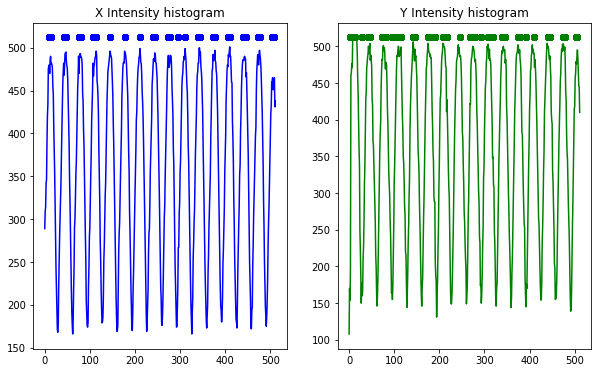

Mean Diameter (along x): 17.20689655172414
Reference Circle: ( 10.0 1.0 )
Grid X Position: [  8.          12.          28.          44.5         61.
  77.16666667  93.16666667 110.5        129.5        161.
 194.         226.         242.5        259.         276.25
 287.25       303.         325.         342.         358.5
 375.         391.5        408.5        425.25       441.25
 445.         459.5        474.         490.         506.5
 511.5       ]
Grid Y Position: [ -1.5     3.5     9.25   20.25   35.5    45.     60.     75.     79.5
  88.5   100.5   107.5   110.5   113.5   128.5   144.5   161.    178.
 185.5   199.    212.5   230.875 256.375 271.    277.    286.    299.5
 309.5   315.5   329.    340.5   344.    360.    376.    385.5   401.
 424.5   442.5   459.    475.5   490.5   504.5   507.5  ]


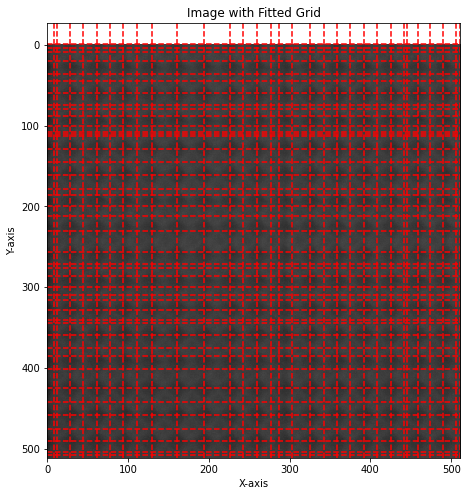

In [10]:
im = cv2.imread(r"../img/nice_mla_cercles_low.png")
calibrate_grid(im)

## SVD Method

This algorithm consist in solving a linear equation with singular value decomposition method. For this method, it is needed to have at least the circle position information, what can be easily obtained by the intensity histograms.

In order to facilitate the construction of matrix, the problem were defined as the following:

$$
B = AX \implies 
\begin{bmatrix}
c_{x_1} \\
c_{x_2} \\
\cdots \\
c_{x_i} \\
\cdots \\
c_{x_n} \\
c_{y_1} \\
c_{y_2} \\
\cdots \\
c_{y_i} \\
\cdots \\
c_{y_n} \\
\end{bmatrix}
=
\begin{bmatrix}
1 & 0 & 0 & 0 \\
1 & 0 & 1 & 0 \\
\vdots & \vdots &\vdots  &\vdots\\
1 & 0 & V_X & 0 \\
\vdots & \vdots &\vdots  &\vdots\\
1 & 0 & n - 1 & 0 \\
0 & 1 & 0 & 0 \\
0 & 1 & 0 & 1 \\
\vdots & \vdots &\vdots  &\vdots\\
0 & 1 & 0 &  V_Y\\
\vdots & \vdots &\vdots  &\vdots\\
0 & 1 & 0 & n - 1 \\
\end{bmatrix}
\cdot
\begin{bmatrix}
c_{x_0} \\
c_{y_0} \\
dx \\
dy \\
\end{bmatrix}
\text{ where }
\begin{cases}
V_X &= i \mod n_x\\
V_Y &= \left\lfloor \frac{i}{n_y} \right\rfloor
\end{cases}
$$
with $n_x$ and $n_y$ being the number of circles in the correspoding axe. 

$B$ is the matrix containing the circles center coordinates. The matrix is rearranged such as the first half of the elements are x coordinates and the rest are y coordinates. This facilitates the construction of the matrix $A$.

$X$ is the unknown variable. The center of a reference circle $(c_{x_0}, c_{y_0})$ and the step into x and y direction, $dx$ and $dy$.

$A$ is the matrix that expresses the linear relation between the circles location and the unknown variables. Each x coordinates of a circles has as reference the $c_{x_0}$ and an amount of times of $dx$. The same is done for the y coordinates.

The value of the third column of $c_{x_i}$ elements is the modulo of the row index with the number of circles in the X-axis.
The value of the fourth column of $c_{y_i}$ elements is the integer division of the row index with the number of circles in the Y-axis.

This linear problem will be solved with SVD method, available in the numpy library. The solution is done by:
$$
B = A\cdot X = USV\cdot X \implies X = V^{T}S^{-1} U^{T} \cdot B
$$

Numpy can make the decomposition and python the matrix multiplication. Then, let's dive into the algorithm:

In [32]:
def calibrate_svd(image, gauss_kernel=(15, 15), block_size=31, c=3, cluster_distance=10):
    # Threshold image
    plt.figure(figsize=FIGSIZE)
    
    plt.imshow(image, cmap="gray")

    thresh = generate_threshold_img(image, gauss_kernel, block_size, c)
    plt.figure(figsize=FIGSIZE)
    plt.imshow(thresh, cmap="gray")
    # Get circles based on the fitted grid
    circles, nb_x, nb_y = get_circles(thresh, cluster_distance)
    ## Sort by Y position then by X.
    circles = circles[np.lexsort((circles[:, 0], circles[:, 1]))]
    ## Construct matrix B of the equation AX = B
    B = np.concatenate((circles[:,0], circles[:,1])).reshape(-1,1)

    ## Construct matrix A of the equation
    num_circles = len(circles)
    A = np.zeros((num_circles*2, 4))

    A[:num_circles, 0] = 1
    A[:num_circles, 2] = np.tile(np.arange(nb_x), num_circles // nb_x + 1)[:num_circles]
    A[num_circles:, 1] = 1
    A[num_circles:, 3] = np.repeat(np.arange(nb_y), nb_x)[:num_circles]

    # Find SVD of A
    U, S, Vt = np.linalg.svd(A, full_matrices=False)
    # Compute the pseudo-inverse of S
    S_inv = np.diag(1 / S)
    # Solve for X using SVD components
    cx_0, cy_0, dx, dy = Vt.T @ S_inv @ U.T @ B

    fig = plt.figure(figsize=FIGSIZE)
    plt.imshow(image, cmap='gray')

    print("X coordinates")
    
    # Add vertical grid lines
    for i in np.arange(dx, im.shape[0], dx):
        plt.axhline(i, color='red', linestyle='--', linewidth=1)
        print(i)
        
    print("Y coordinates")

    # Add horizontal grid lines
    for j in np.arange(dy, im.shape[1], dy):
        plt.axvline(j, color='red', linestyle='--', linewidth=1)
        print(j)

    plt.show()
    
    print(f"Reference circle: ({cx_0[0]},{cy_0[0]})")
    print(f"Steps/Mean diameters: dx {dx[0]} dy {dy[0]}")
    

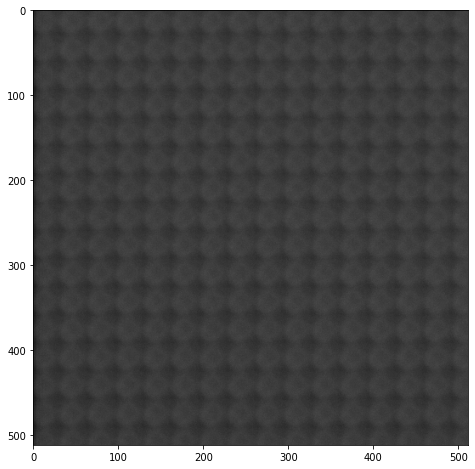

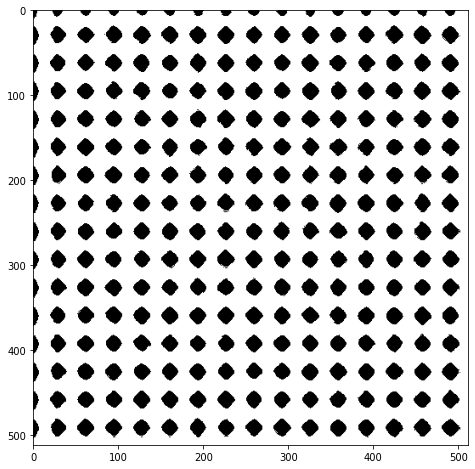

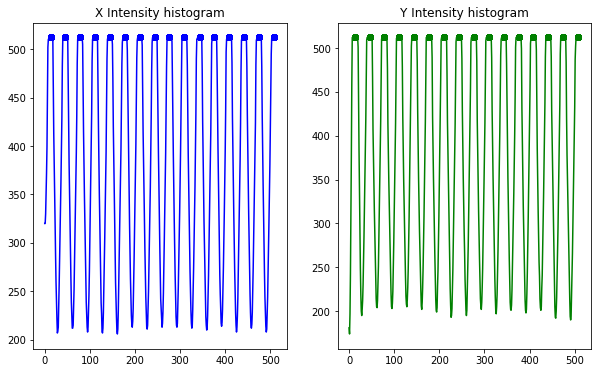

X coordinates
33.0
66.0
99.0
132.0
165.0
198.0
231.0
264.0
297.0
330.0
363.0
396.0
429.0
462.0
495.0
Y coordinates
32.98235294117647
65.96470588235294
98.94705882352942
131.9294117647059
164.91176470588238
197.89411764705886
230.8764705882353
263.8588235294118
296.84117647058827
329.82352941176475
362.80588235294124
395.78823529411767
428.77058823529416
461.75294117647064
494.7352941176471


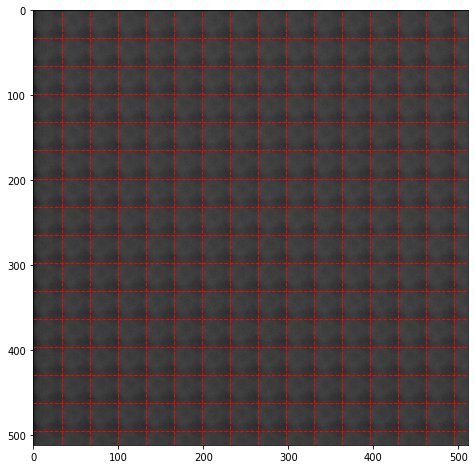

Reference circle: (12.749999999999966,12.569852941176434)
Steps/Mean diameters: dx 33.0 dy 32.98235294117647


In [33]:
calibrate_svd(im)

Both methods seems to work fine and can be implemented into the software. However, there is a need to check the following points:

- Results precision: whether the result is correct or not.
- Results stability: whether the result converge easily or not.
- Implementation difficulty: whether the algorithm can be easily converted to C++.
    - Note: there is a need to find a analoguous math module of numpy.
- Performance: which is the more efficient and can be computed in real time for user interaction.

# Tests

FIRST ALGORITHM
SECOND ALGORITHM


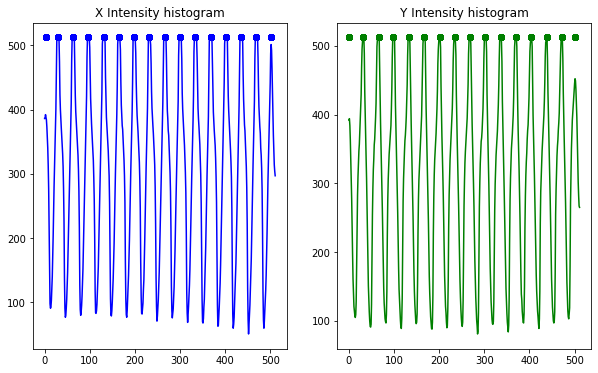

33.6875
67.375
101.0625
134.75
168.4375
202.125
235.8125
269.5
303.1875
336.875
370.5625
404.25
437.9375
471.625
505.3125


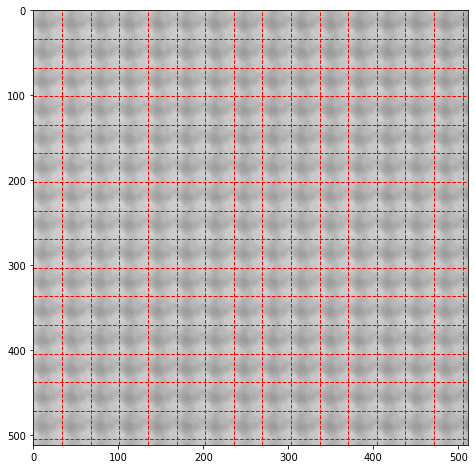

Reference circle: (-2.9227941176470793,-1.2499999999999893)
Steps/Mean diameters: dx 33.67720588235292 dy 33.6875


In [19]:
test_1 = cv2.imread("../img/pcv_image_calibration_medium_exposure.png")
print("FIRST ALGORITHM")
#calibrate_grid(test_1)
print("SECOND ALGORITHM")
calibrate_svd(test_1)  # grid x-y intersection on circle center
#calibrate_svd(~test_1) # grid cell centered in the circle center

In [ ]:
test_2 = ~cv2.imread("../img/not_good/nice_mla_cercles.png")
## The inverted image gives a better result than the original.
## Detecting the peaks in the original is difficult because there is too many local maximums.
## The inverted has more obvious maximums.
print("FIRST ALGORITHM")
#calibrate_grid(test_2, cluster_distance=10)
print("SECOND ALGORITHM")
calibrate_svd(test_2, cluster_distance=10) 

In [ ]:
test_3 = cv2.imread("../img/not_good/low_aperture.png")
print("FIRST ALGORITHM")
#calibrate_grid(test_3, cluster_distance=10)
print("SECOND ALGORITHM")
calibrate_svd(test_3, cluster_distance=10) 

## Option & Parameters

In order to get the correct calibration, the user should:
1. **Adapt the apertude**: Light coming through each microlens should be ideal to it to be highlighted from the background.
    
2. **Invert or not the image**: With the default parameters, invert the image could generate a good result whenever the intensity histogram of the image is to noisy (plenty of local maximums).
    
3. **Adapt cluster distace**: If the intensity histogram is too noisy, there may be very close local maximum that should be merged together. Increasing the cluster distance will merge those points and so, "reduce" the noise.
    
4. **Adapt Gaussian blur kernel**: If the original image has too much noise, increase the kernel will give a more reliable intensity histogram with more well defined local maximums.
    
5. **Adapt Threshold parameters**: The effect of this change is not known yet.